## 1.Data Preprocessing

### Cleaning + Estimating volatility
- Ensuring validity of datapoints 
- Cleaning out deviations | Isolated points | etc ...
- Estimating Volatility

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime

df = pd.read_csv("/Users/aleksandr/Desktop/Meta_Test.csv")
df = df.dropna()

In [11]:
from preprocess_td import preprocess_tick_data

# Would be lovely to estimate parameters of function
df_clean, df_diagnostics, outlier_counter = preprocess_tick_data(df)
df = df_clean
df = df.drop(columns="VOLATILITY")

Starting preprocessing with 570771 rows
After filtering trading hours: 282810 rows
After cleaning outliers: 282301 rows
Final clean dataset: 278585 rows

Outlier counts by detection method:
  zscore: 64
  extreme_deviation: 69
  isolated_point: 390
  price_reversal: 93
  market_open_artifact: 0
  timestamp_group: 34
  price_velocity: 3703
  suspicious_cluster: 52
  wavelet_outlier: 24


In [12]:
# Would be lovely to estimate parameters of function
from volatility_estimation import estimate_tick_volatility

df = estimate_tick_volatility(df, method = 'wavelet')

Estimating advanced tick-level volatility for 278585 ticks...
Computing wavelet-based volatility for META.O...
Completed advanced tick-level volatility estimation


In [15]:
df.drop(columns=['return', "SYMBOL"], inplace= True)
df.rename(columns={'wavelet_vol' : 'Volatility', 
                  'TIMESTAMP':'Timestamp',
                   'VALUE' : 'Value',
                   'VOLUME' : 'Volume'}, inplace=True)
df.head()

KeyError: "['return', 'SYMBOL'] not found in axis"

## 2. Synthetic Noise Injection 

Suppose that, the latent log-price Xt is an Ito-semimartingale of the form 

$dX_t = b_t dt + \sigma_t dW_t + dJ_t,$  
$d\sigma_t = \tilde{b}_t dt + \tilde{\sigma}^{(1)}_t dW_t + \tilde{\sigma}^{(2)}_t d\tilde{W}_t + d\tilde{J}_t$





### Market Microstructure Noise:
- Quote Spread Noise: The price fluctuation caused by trades alternating between bid and ask prices, creating a "bouncing" effect that obscures the true efficient price.

- Order Flow Noise: Price movements driven by the imbalance between buy and sell orders, where persistent directional trading pressure can create temporary price trends away from the efficient price.

- Strategic Order Noise: Price distortions created when large traders split their orders into smaller pieces to minimize market impact.

- Quote Positioning Noise: Price effects from market makers strategically placing and canceling quotes to create false impressions of supply and demand.

In [7]:
# Generate 1000 noise samples
from microstructure_simulator import MarketMicrostructureSimulator

simulator = MarketMicrostructureSimulator(n_samples=1000)
result = simulator.simulate_full_microstructure()
noise_components = simulator.extract_noise_components(result)
noise_components["total_noise"][:10]

Simulating efficient price process...
Adding quote spread noise...
Simulating order flow noise...
Simulating strategic order splitting...
Simulating strategic quote positioning...


array([-0.03378606,  0.03567945,  0.09798677,  0.10495182, -0.12444308,
       -0.01157954, -0.20460404,  0.04836754, -0.03279175,  0.04115321])

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from preprocess_td import preprocess_tick_data
from volatility_estimation import estimate_tick_volatility

df = pd.read_csv("/Users/aleksandr/Desktop/Meta_Test.csv")
df = df.dropna()

# Would be lovely to estimate parameters of function
df_clean, df_diagnostics, outlier_counter = preprocess_tick_data(df)
df = df_clean
df = df.drop(columns="VOLATILITY")

df = estimate_tick_volatility(df, method = 'wavelet')

df.drop(columns=['return', "SYMBOL"], inplace= True)
df.rename(columns={'wavelet_vol' : 'Volatility', 
                  'TIMESTAMP':'Timestamp',
                   'VALUE' : 'Value',
                   'VOLUME' : 'Volume'}, inplace=True)
df.head()

Starting preprocessing with 570771 rows
After filtering trading hours: 282810 rows
After cleaning outliers: 282301 rows
Final clean dataset: 278585 rows

Outlier counts by detection method:
  zscore: 64
  extreme_deviation: 69
  isolated_point: 390
  price_reversal: 93
  market_open_artifact: 0
  timestamp_group: 34
  price_velocity: 3703
  suspicious_cluster: 52
  wavelet_outlier: 24
Estimating advanced tick-level volatility for 278585 ticks...
Computing wavelet-based volatility for META.O...
Completed advanced tick-level volatility estimation


,Timestamp,Value,Volume,Volatility
0,2025-01-30 09:30:00.740000+00:00,694.24,13.0,0.000260
1,2025-01-30 09:30:00.740000+00:00,694.17,15.0,0.000260
2,2025-01-30 09:30:00.740000+00:00,694.17,15.0,0.000261
3,2025-01-30 09:30:00.740000+00:00,694.11,8.0,0.000261
4,2025-01-30 09:30:00.740000+00:00,694.10,249.0,0.000261


In [1]:
file_path = "/Users/aleksandr/Desktop" + "/my_data.csv"
df_sample = df[:2000]
# Save DataFrame to CSV
df_sample.to_csv(file_path, index=False) 

NameError: name 'df' is not defined

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/aleksandr/Desktop/my_data.csv")

In [13]:
# Import the main identifier class
from volatility_regimes_identifier import VolatilityRegimesIdentifier
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Sample the data
df_sample = df[:600]

print("Beginning volatility regime detection...")
start_time = datetime.now()

# Initialize the identifier with our data
identifier = VolatilityRegimesIdentifier()

# Identify volatility regimes
print("\nIdentifying volatility regimes...")
df_with_regimes = identifier.identify_regimes(
    df_sample,
    timestamp_col='Timestamp',
    price_col='Value',
    volume_col='Volume',
    volatility_col='Volatility',
    n_regimes=3,  # Set to None for automatic regime detection
    window_sizes=[10, 30, 50],  # Window sizes for feature extraction
    top_features=10,  # Number of top features to use
    alpha=0.5,  # Weight for temporal component
    beta=0.1,  # Decay rate for temporal distance
    sample_size=500,  # Size of sample to use (matching our df_sample size)
    sampling_method='sequential',  # Method to use for sampling
    smooth_sequences= True,
    min_sequence_length=20
)

end_time = datetime.now()
print(f"\nRegime detection completed in {end_time - start_time}")


regime_stats = identifier.get_regime_statistics()

print("\n=== Volatility Regime Statistics ===")
for stat in regime_stats['regime_stats']:
    regime_id = stat['regime_id']
    size = stat['size']
    mean_vol = stat.get('mean_vol', float('nan'))
    duration = stat.get('duration', float('nan'))
    
    print(f"Regime {regime_id+1}:")
    print(f"  - Size: {size} ticks ({size/len(df_sample)*100:.1f}% of data)")
    print(f"  - Mean volatility: {mean_vol:.6f}")
    print(f"  - Duration: {duration:.2f} seconds")
    print()

print("\n=== Regime Transition Probabilities ===")
transition_probs = regime_stats['transition_probs']
for i in range(len(transition_probs)):
    for j in range(len(transition_probs[i])):
        if transition_probs[i, j] > 0:
            print(f"  Regime {i+1} → Regime {j+1}: {transition_probs[i, j]:.3f}")

Beginning volatility regime detection...

Identifying volatility regimes...

Starting volatility regime detection at 20:48:36

=== Stage 1: Learning Patterns from Sample ===
Sampling completed in 0.00 seconds

--- STEP 1: Computing Features ---

--- STEP 1: Computing Microstructure Features ---
Time features computed in 0.01 seconds
Computing microstructure features...
Microstructure features computed in 0.01 seconds
Microstructure features computed in 0.01 seconds
Computing order flow metrics...
Order flow metrics computed in 0.01 seconds
Order flow metrics computed in 0.01 seconds
Computing DMI features...
DMI features computed in 0.01 seconds
DMI features computed in 0.01 seconds
Extracted 46 features in total 0.04 seconds
Feature computation completed in 0.04 seconds

--- STEP 2: Enhancing Features ---

--- STEP 2: Applying Information-Theoretic Feature Enhancement ---
Estimating Shannon entropy with heavy-tail adjustment...
Shannon entropy estimation completed in 0.16 seconds
Comp

In [14]:
df_with_regimes["regime"].value_counts()

regime
2    352
0    155
1     93
Name: count, dtype: int64

In [15]:
# Calculate sequence lengths for each regime
regime_sequences = []
current_regime = None
current_length = 0

for regime in df_with_regimes["regime"]:
    if current_regime is None:
        current_regime = regime
        current_length = 1
    elif regime == current_regime:
        current_length += 1
    else:
        regime_sequences.append((current_regime, current_length))
        current_regime = regime
        current_length = 1

# Add the last sequence
if current_length > 0:
    regime_sequences.append((current_regime, current_length))

# Analyze sequence lengths by regime
print("\n=== Regime Sequence Length Statistics ===")
for regime in sorted(df_with_regimes["regime"].unique()):
    lengths = [length for r, length in regime_sequences if r == regime]
    if lengths:
        print(f"\nRegime {regime}:")
        print(f"  Min sequence length: {min(lengths)}")
        print(f"  Max sequence length: {max(lengths)}")
        print(f"  Mean sequence length: {sum(lengths)/len(lengths):.2f}")
        print(f"  Number of sequences: {len(lengths)}")



=== Regime Sequence Length Statistics ===

Regime 0:
  Min sequence length: 155
  Max sequence length: 155
  Mean sequence length: 155.00
  Number of sequences: 1

Regime 1:
  Min sequence length: 93
  Max sequence length: 93
  Mean sequence length: 93.00
  Number of sequences: 1

Regime 2:
  Min sequence length: 352
  Max sequence length: 352
  Mean sequence length: 352.00
  Number of sequences: 1


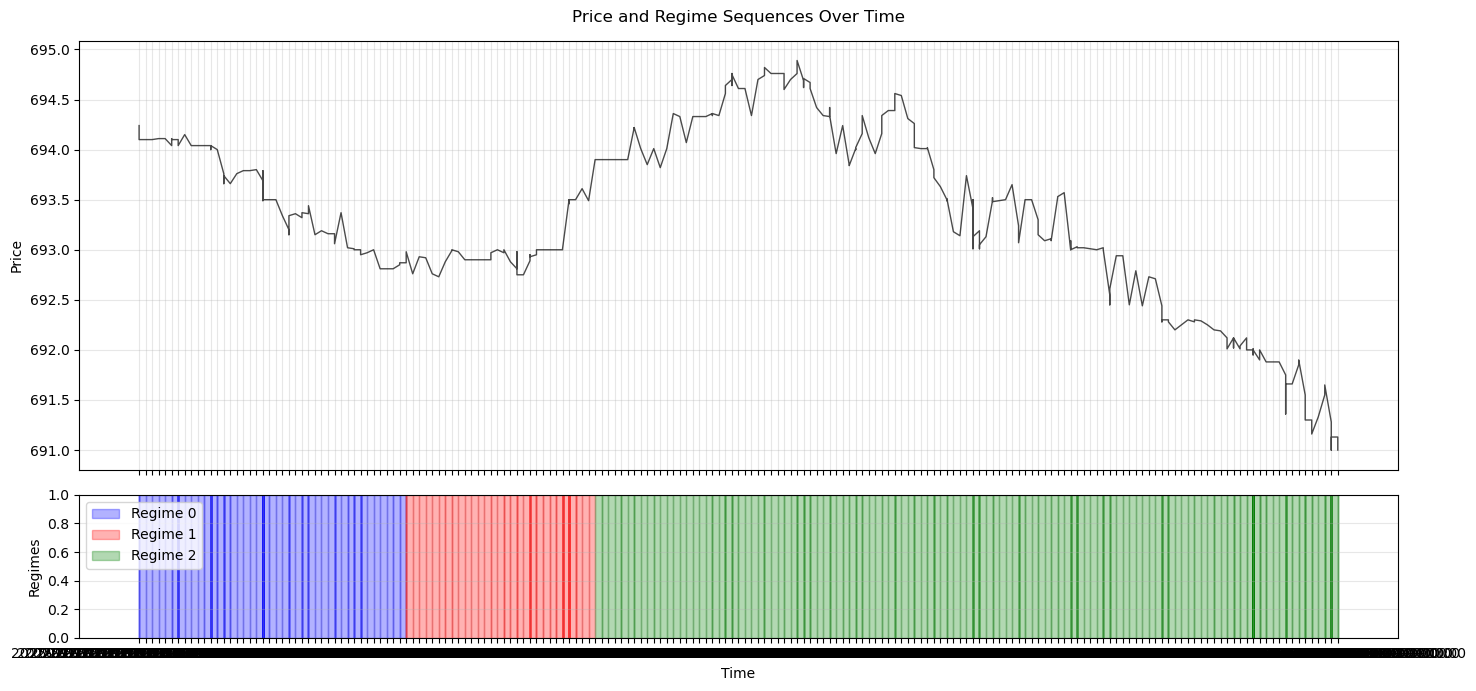

In [16]:
import matplotlib.pyplot as plt

# Create figure and axis with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharex=True, height_ratios=[3, 1])

# Plot price data
ax1.plot(df_with_regimes['Timestamp'], df_with_regimes['Value'], color='black', alpha=0.7, linewidth=1)
ax1.set_ylabel('Price')
ax1.grid(True, alpha=0.3)

# Plot regimes
colors = ['blue', 'red', 'green']
labels = ['Regime 0', 'Regime 1', 'Regime 2']
used_labels = set()

for i in range(len(df_with_regimes)-1):
    regime = df_with_regimes['regime'].iloc[i]
    color = colors[regime]
    
    # Only add label once per regime for legend
    if regime not in used_labels:
        ax2.axvspan(df_with_regimes['Timestamp'].iloc[i], 
                   df_with_regimes['Timestamp'].iloc[i+1],
                   color=color, alpha=0.3, label=labels[regime])
        used_labels.add(regime)
    else:
        ax2.axvspan(df_with_regimes['Timestamp'].iloc[i],
                   df_with_regimes['Timestamp'].iloc[i+1], 
                   color=color, alpha=0.3)

ax2.set_xlabel('Time')
ax2.set_ylabel('Regimes')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Price and Regime Sequences Over Time')
plt.tight_layout()
plt.show()

## 3. Windowing data
- Split the series into overlapping or non-overlapping windows.
- Ensure no future leakage.

## 3. Model Architecture Adaptations

Modify the original CSDI code (GitHub) for denoising:

### Remove Imputation Logic:
- Delete code blocks that handle missing value imputation.

### Time Embeddings:
- Encode irregular timestamps as sinusoidal embeddings (normalized to [0,1]).

### Conditioning Mechanism:
- Use the noisy input as the conditional context (instead of partial observations).

### Diffusion Process:
- Use the original diffusion steps but disable masking (all positions are observed).
- Adjust the noise schedule (β) to match financial noise characteristics.


## 4. Training Pipeline

**Objective:** Learn to reverse the diffusion process conditioned on noisy ticks.

### Inputs:
- **noisy_data:** Corrupted ticks (price, volume, etc.).
- **mask:** All ones (no missing data).
- **time_embeddings:** Encoded timestamps.

### Forward Process:
- Gradually add Gaussian noise to `noisy_data` across diffusion timesteps.
- Forward Process: Replace Gaussian SDE with a market-realistic stochastic process.

### Reverse Process:
- Train the model to predict the score (gradient) to denoise the data.

### Loss Function:
- Weighted MSE between predicted and true noise at each diffusion step.

## 5. Key Functions to Implement

### Data Loader:
```python
def load_tick_data():
    """Reads raw ticks and converts to windowed sequences."""
    pass

def inject_microstructure_noise():
    """Adds synthetic bid-ask bounce, order flow noise."""
    pass
```

### Time Embeddings:
```python
def encode_timestamps():
    """Converts irregular timestamps to continuous embeddings."""
    pass
```

### Diffusion Utils:
```python
def beta_scheduler():
    """Defines the noise schedule (linear, cosine, etc.)."""
    pass

def q_sample():
    """Forward diffusion process (adding noise)."""
    pass
```

### Model:
```python
class ConditionalScoreModel:
    """Modified CSDI backbone (transformer/TCN)."""
    pass

def train_step():
    """Computes loss and updates weights."""
    pass
```

## 6. Training Process

### Hyperparameters:
- Diffusion steps (`T=1000`), learning rate (`1e-4`), batch size (`64`).
- Noise schedule (e.g., `beta_start=1e-4`, `beta_end=0.02`).

### Training Loop:
For each batch:
1. Generate noisy data via `inject_microstructure_noise()`.
2. Compute time embeddings for irregular timestamps.
3. **Forward pass:** Corrupt noisy data with diffusion.
4. **Reverse pass:** Predict denoised data.
5. Update model weights via gradient descent.

### Checkpointing:
- Save model weights periodically (e.g., every epoch).
- Track validation loss on a held-out tick dataset.

## 7. Validation & Testing

### Metrics:
- **Reconstruction Loss:** MSE between denoised and clean data (if synthetic).
- **Volatility Consistency:** Compare realized volatility of raw vs. denoised data.
- **Microstructure Preservation:** Autocorrelation of trade signs.

### Visual Checks:
- Plot raw vs. denoised ticks (ensure no new timestamps are added).

## 8. Deployment Pipeline

### Preprocessing:
- Normalize new tick data using the same scaler from training.
- Encode timestamps.

### Inference:
- Run the trained CSDI in reverse diffusion mode with `mask=1`.

### Postprocessing:
- Inverse-transform normalized denoised data.